# Lecture 10: BVP's, Jacobi Method

**Overview:**
* Laplace and Poisson equations.
* The Jacobi (diffusion) method.

**Next Lecture:**
* Simple random systems and diffusion.
---


## Tasks
- Make sure you understand the Jacobi update using array slicing.
- Find V(x,y) and E(x,y) for an infinitely long rectangular cylinder with the two vertical walls at a potential of +1 and the horizontal walls at a potential of -1.
- Can you modify the Jacobi method to implement a Gauss-Seidel method? What about including overrelaxation? Both of these are much easier using the looping Jacobi method below.
- Include a term for a charge in the Jacobi algorithm (Poisson equation).
- Find V(x,y) and E(x,y) for a small square of charge +q positioned in between two parallel plates at V = -1 and V = +1.

In [2]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

### Define boundaries with the functions in this cell

In [3]:
def free_space(phi): return phi

def parallel_plate(phi):
    """ 
    define parallel plate potential
    """
   # the operator // is floor division i.e divide and then round down to nearest integer.
   # Using this ensures that the result is an integer so we can use it to index arrays.
    
    n, m = np.shape(phi)
    w = n//2
    h = n//3  # span 1/3 of grid in height`
    
    right = w + h//2 #position of plate 1
    left = w - h//2  # position of plate 2
    phi[h:2*h, left] = - 1
    phi[h:2*h, right] =  1
    
    return phi

def box():
    # define boundary conditions for a box
    
    return phi

def pipe(phi):
    n,m = np.shape(phi)
    r = n/200
    tol = np.sqrt(n**2 + m**2)

    X,Y = np.meshgrid(range(-n//2, n//2+1), range(-m//2, m//2+1))
    Z = np.sqrt((X-n//8)**2 + (Y)**2)
    
    idx = np.nonzero(abs(Z-r) < 1)
    phi[idx] =  1
    return phi



### Define Jacobi algorithm below :

**First using loops and jit to speed up the process** 
try removing `@jit`, are you patient enough to wait for this to finish?

In [4]:
@jit
def jacobi(V,Vnew,M,N):
    for ii in range(M):
        for jj in range(N):
            if ii == 0 or jj == 0 or ii == M or jj == N:
                Vnew[ii,jj] = V[ii,jj]
            else :
                Vnew[ii,jj] = (V[ii+1,jj]+V[ii-1,jj]+V[ii,jj+1]+V[ii,jj-1])/4
    return Vnew

def invDel2_loops(b, boundary,  dx=1.0, converge = 1e-6):
    """ This is the Jacobi algorithim 
    Specialized to two dimensions so that plotting is easier.
    """
    V = boundary(np.zeros(b.shape, float))  # potential values at step n of the iteration   
    Vnew = np.zeros(b.shape, float) # updated potential 
    Npoints = len(b.flatten())

    t = 0  # transient before checking for convergence
    dV = converge*10  #make sure we run through transient
    
    while(dV > converge): 
        # move the loops outside to use jit
        Vnew = jacobi(V,Vnew,V.shape[0]-1,V.shape[1]-1)
        
        # enforce bc's at every iteration
        Vnew = boundary(Vnew)


        # wait for transient before checking convergence
        if t > 100 : 
            dV = np.sum(abs(Vnew - V))/Npoints
        # Note the explicit indexing (V[:,:]) without it Vnew will be updated with V
        V[:,:] = Vnew 
        # for mor complex objects i.e. list with sublists use deepcopy
        t+=1
   
    return Vnew

**Now using numpy array slicing** 

make sure you understand how this is working

In [5]:
def invDel2(b, boundary,  dx=1.0, converge = 1e-6):
    """ This is the Jacobi algorithim 
    Specialized to two dimensions so that plotting is easier.
    """
    V = boundary(np.zeros(b.shape, float))  # potential values at step n of the iteration   
    Vnew = np.zeros(b.shape, float) # updated potential 
    Npoints = len(b.flatten())

    t = 0  # transient before checking for convergence
    dV = converge*10  #make sure we run through transient
    
    while(dV > converge): 
        # this update fixes V along edges = 0
        Vnew[1:-1, 1:-1] = (V[1:-1,2:] + V[1:-1,:-2] + V[2:,1:-1] \
                + V[:-2,1:-1] - (dx*dx)*b[1:-1,1:-1])/4
        
        # enforce the boundary conditions at every update
        Vnew = boundary(Vnew)
        
        # wait for transient before checking convergence
        if t > 100 : 
            dV = np.sum(abs(Vnew - V))/Npoints
        
        # Note the explicit indexing (V[:,:]) without it Vnew will be updated with V
        V[:,:] = Vnew 
        # for mor complex objects i.e. list with sublists use deepcopy
        t+=1
   
    return Vnew

### Now back to the problem at hand, Determine potential and field

In [6]:
N = 200 #grid points
dx = 1/N

# generate coordinates for each grid point
# only required for plotting E-field
X,Y = np.meshgrid(range(-N//2, N//2+1), range(-N//2, N//2+1))


# the charge distrubution defines space for us
# empty space, no charge
rho = np.zeros([N+1, N+1])
#rho = pipe(rho)*-5000

# solution from relaxation

# using loops
phi = invDel2_loops(rho, parallel_plate, dx)

# or using array slicing
#phi = invDel2(rho, parallel_plate, dx)


# Calculate the electric field
EY, EX = -1*np.array(np.gradient(phi))
magE = np.sqrt(EX**2 + EY**2)

# Note, this step was not completed in shared notebook, so plots will look a bit messy
# supress division by zero error output
np.seterr(divide = 'ignore', invalid = 'ignore')
EX= np.divide(EX,magE)
EY= np.divide(EY,magE)


### Make Plots

<ipython-input-7-3e87dab097c0>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  m1 = ax1.pcolormesh(X, Y, phi, cmap = 'RdBu')
<ipython-input-7-3e87dab097c0>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  m2 = ax2.pcolormesh(X,Y,magE, cmap = 'Reds')


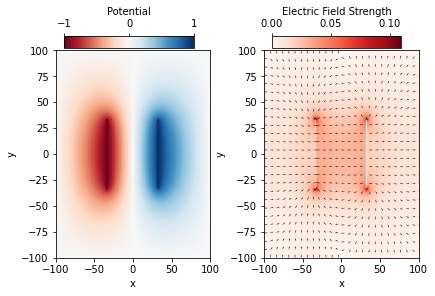

In [7]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# plot potential
m1 = ax1.pcolormesh(X, Y, phi, cmap = 'RdBu')

# add an axes to put colorbar is custom location
cax1 = fig.add_axes([0.14,0.87,0.3,0.04])
# create colorbar
cbar = fig.colorbar(m1,cax1, orientation = 'horizontal', ticklocation = 'top', ticks = [-1,0,1])
cbar.set_label('Potential')

# add contour lines
ax1.contour(X,Y,phi, cmap = 'RdBu')
ax1.set_xlabel("x")
ax1.set_ylabel("y")

# plot E-field 
m2 = ax2.pcolormesh(X,Y,magE, cmap = 'Reds')

cax2 = fig.add_axes([0.62,0.87,0.3,0.04])
cbar2 = fig.colorbar(m2,cax2,orientation = 'horizontal', ticklocation = 'top' )
cbar2.set_label('Electric Field Strength')
ax2.quiver(X[::8,::8],Y[::8,::8],EX[::8,::8], EY[::8, ::8], units = 'width') 
ax2.set_xlabel("x")
ax2.set_ylabel("y")


fig.subplots_adjust(left = 0.12,right = 0.96, bottom = 0.14, top = 0.86, wspace = 0.35, hspace = 0.35)

